In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.insert(1, '../domino/libs')
sys.path.insert(1, '../domino')
sys.path.insert(1, '/home/earendil/Documents/MyLib')

style.use('/home/earendil/Documents/MyLib/big_plt_style.mplstyle')

import pandas as pd

from libs.utilities import domino_mysql_server, read_mysql

# Pulling data

In [237]:
model_version = '1.13'
scenario_id = -20

n_iter = 31
n_iters = [31, 32, 33, 34, 35, 36, 37]#[0, 1, 2, 3, 4, 5]

## Single iteration, historical data, and multiple iterations

In [223]:
with domino_mysql_server(profile='remote_direct') as connection:
#     # Get model output
#     query = "SELECT * FROM output_flights where model_version='" + model_version +\
#             "' AND scenario_id=" + str(scenario_id) + " AND n_iter=" + str(n_iter)
#     df = read_mysql(query=query, engine=connection['engine'])

    query = """SELECT
            ddr.ifps_id,
            f.callsign as flight_number,
            f.registration as tail_number,
            f.origin as origin_airport,
            f.destination as destination_airport,
            origin.mean_taxi_out,
            origin.std_taxi_out,
            destination.mean_taxi_in,
            destination.std_taxi_in,
            f.sobt,
            ddr.aobt,
            ddr.take_off_time,
            ddr.take_off_time_sch,
            f.sibt,
            ddr.landing_time,
            ddr.landing_time_sch,
            CASE ddr.landing_time
                WHEN NULL THEN NULL
                ELSE ddr.landing_time + INTERVAL mean_taxi_in MINUTE
            END AS aibt,
            ddr.cancelled,
            ddr.distance,
            ddr.distance_sch
            FROM domino_environment.flight_schedule AS f
            JOIN domino_environment.ddr_for_analyses AS ddr ON ddr.ifps_id=f.ifps_id
            JOIN (
                SELECT a_s_o.icao_id, 
                        IF(t_o.mean_txo is not NULL, t_o.mean_txo, a_s_o.mean_taxi_out) as mean_taxi_out,
                        IF(t_o.std_deviation is not NULL, t_o.std_deviation, a_s_o.std_taxi_out) as std_taxi_out
                FROM domino_environment.airport_info_static AS a_s_o
                LEFT JOIN domino_environment.taxi_out_static AS t_o ON t_o.icao_id=a_s_o.icao_id
                ) as origin ON origin.icao_id = f.origin
            JOIN (SELECT a_s_d.icao_id,
                        IF(t_i.mean_txi is not NULL, t_i.mean_txi, a_s_d.mean_taxi_in) as mean_taxi_in,
                        IF(t_i.std_deviation is not NULL, t_i.std_deviation, a_s_d.std_taxi_in) as std_taxi_in
                FROM domino_environment.airport_info_static AS a_s_d
                LEFT JOIN domino_environment.taxi_in_static AS t_i ON t_i.icao_id=a_s_d.icao_id
                ) as destination ON destination.icao_id = f.destination"""
    df_hist = read_mysql(query=query, engine=connection['engine'])

DB connection to 127.0.0.1 with ssh tunneling through archdb.fst.westminster.ac.uk


In [224]:
len(df_hist)

27261

In [238]:
with domino_mysql_server(profile='remote_direct') as connection:
    query = "SELECT * FROM output_flights where model_version='" + model_version +\
            "' AND scenario_id=" + str(scenario_id) + " AND ("

    for n in n_iters:
        query += 'n_iter=' + str(n) + ' OR '

    query = query[:-4] + ')'

    df = read_mysql(query=query, engine=connection['engine'])
    print (query)

DB connection to 127.0.0.1 with ssh tunneling through archdb.fst.westminster.ac.uk
SELECT * FROM output_flights where model_version='1.13' AND scenario_id=-20 AND (n_iter=31 OR n_iter=32 OR n_iter=33 OR n_iter=34 OR n_iter=35 OR n_iter=36 OR n_iter=37)


In [239]:
# Get the flight schedules to have the relationships between id and ifps_id
with domino_mysql_server(profile='remote_direct') as connection:
    query = "SELECT of.id, fs.ifps_id FROM output_flights of JOIN flight_schedule as fs ON fs.nid=of.id WHERE model_version='"\
    + model_version + "' AND scenario_id=" + str(scenario_id) + " AND n_iter=" + str(n_iter)

    df_sch = read_mysql(query=query, engine=connection['engine'])
    df_sch.rename(columns={'nid':'id'}, inplace=True)
    
df_sch.head()

DB connection to 127.0.0.1 with ssh tunneling through archdb.fst.westminster.ac.uk


,id,ifps_id
0,66912,AA34820675
1,67332,AA34820700
2,60425,AA34850875
3,34547,AA34859875
4,34696,AA34860589


## Derived metrics

In [240]:
#df_hist['sibt']

In [241]:
df['departure_delay'] = (df['aobt']-df['sobt']).dt.total_seconds()/60.
df['arrival_delay'] = (df['aibt']-df['sibt']).dt.total_seconds()/60.
df['scheduled_G2G_time'] = (df['sibt']-df['sobt']).dt.total_seconds()/60.
df['actual_G2G_time'] = (df['aibt']-df['aobt']).dt.total_seconds()/60.
df['travelling_time_diff'] = ((df['aibt']-df['aobt']) - (df['sibt']-df['sobt'])).dt.total_seconds()/60.
df['scheduled_flying_time'] = df['m1_fp_time_min']
df['actual_flying_time'] = df['m3_fp_time_min']
df['scheduled_flying_distance'] = df['m1_climb_dist_nm'] + df['m1_cruise_dist_nm'] + df['m1_descent_dist_nm']
df['actual_flying_distance'] = df['m3_climb_dist_nm'] + df['m3_cruise_dist_nm'] + df['m3_descent_dist_nm']

df_hist['departure_delay'] = (df_hist['aobt']-df_hist['sobt']).dt.total_seconds()/60.
df_hist['arrival_delay'] = (df_hist['aibt']-df_hist['sibt']).dt.total_seconds()/60.
df_hist['scheduled_G2G_time'] = (df_hist['sibt']-df_hist['sobt']).dt.total_seconds()/60.
df_hist['actual_G2G_time'] = (df_hist['aibt']-df_hist['aobt']).dt.total_seconds()/60.
df_hist['travelling_time_diff'] = ((df_hist['aibt']-df_hist['aobt']) - (df_hist['sibt']-df_hist['sobt'])).dt.total_seconds()/60.
df_hist['scheduled_flying_time'] = (df_hist['landing_time_sch'] - df_hist['take_off_time_sch']).dt.total_seconds()/60.
df_hist['actual_flying_time'] = (df_hist['landing_time'] - df_hist['take_off_time']).dt.total_seconds()/60.
df_hist['taxi_out_traj'] = (df_hist['take_off_time'] - df_hist['aobt']).dt.total_seconds()/60.
df_hist['taxi_out'] = df_hist['mean_taxi_out']
df_hist['taxi_in'] = df_hist['mean_taxi_in']
#df_hist['taxi_in_traj'] = (df_hist['aibt'] - df_hist['landing_time']).dt.total_seconds()/60.
df_hist['scheduled_flying_distance'] = df_hist['distance_sch']/1.852
df_hist['actual_flying_distance'] = df_hist['distance']/1.852
#df_hist['arrival_delay'] = (df_hist['aibt']-df_hist['sibt']).dt.total_seconds()/60.

In [242]:
# For single iteration stuff
df2 = df[df['n_iter']==n_iter]
yo = df2.set_index('id').sort_index()
yoyo = df_sch.set_index('id')
yoyo.sort_index(inplace=True)
df2 = pd.concat([yo, yoyo],
               axis=1)
#df2.join(df_sch, on='id', lsuffix='_out', rsuffix='_sch', how='inner')
#df2.head()

In [243]:
df_hist['ifps_id'] = df_hist['ifps_id'].astype(str)
df2['ifps_id'] = df2['ifps_id'].astype(str)

In [244]:
coin = df_hist[['ifps_id', 'scheduled_flying_distance', 'actual_flying_distance']].set_index('ifps_id')
pouet = df2[['ifps_id', 'scheduled_flying_distance', 'actual_flying_distance']].set_index('ifps_id')
#pouet.join(coin, on='ifps_id', how='inner', lsuffix='hist', rsuffix='sim')
go = pd.concat([coin.rename(columns={col:col+'_hist' for col in coin.columns}), 
                pouet.rename(columns={col:col+'_sim' for col in pouet.columns})],
               axis=1)
go['diff_sch'] = go['scheduled_flying_distance_sim'] - go['scheduled_flying_distance_hist']
go.head()

,scheduled_flying_distance_hist,actual_flying_distance_hist,scheduled_flying_distance_sim,actual_flying_distance_sim,diff_sch
AA34820675,237.580994,197.084233,237.58,237.58,-0.000994
AA34820700,182.505400,182.505400,266.20,257.17,83.694600
AA34850875,633.909287,627.969762,633.91,603.34,0.000713
AA34859875,2258.099352,2247.300216,2413.61,2395.16,155.510648
AA34860589,964.362851,964.362851,964.36,918.23,-0.002851


# Average values

In [245]:
print ('Number of flights:', len(df), len(df2), len(df_hist))

Number of flights: 163566 27261 27261


In [246]:
print ('First values are from model, second ones are from historical data')
print ('Average departure delay:', df['departure_delay'].mean(), df_hist['departure_delay'].mean())
print ('Average arrival delay:', df['arrival_delay'].mean(), df_hist['arrival_delay'].mean())
print ('Average scheduled G2G time:', df['scheduled_G2G_time'].mean(), df_hist['scheduled_G2G_time'].mean())
print ('Average actual G2G time:', df['actual_G2G_time'].mean(), df_hist['actual_G2G_time'].mean())
print ('Average scheduled flying time:', df['scheduled_flying_time'].mean(), df_hist['scheduled_flying_time'].mean())
print ('Average actual flying time:', df['actual_flying_time'].mean(), df_hist['actual_flying_time'].mean())
print ('Average scheduled flying distance:', df['scheduled_flying_distance'].mean(), df_hist['scheduled_flying_distance'].mean())
print ('Average actual flying distance:', df['actual_flying_distance'].mean(), df_hist['actual_flying_distance'].mean())
print ('Average actual taxi-out time:', df['axot'].mean(), df_hist['taxi_out'].mean(), df_hist['taxi_out_traj'].mean())
print ('Average actual taxi-in time:', df['axit'].mean(), df_hist['taxi_in'].mean())
print ('Average G2G diff. time bet. scheduled and actual:', df['travelling_time_diff'].mean(), df_hist['travelling_time_diff'].mean())

First values are from model, second ones are from historical data
Average departure delay: 11.583583588579126 11.42863370138048
Average arrival delay: 6.519262583981585 6.648379247520879
Average scheduled G2G time: 159.46605040167273 159.46605040167273
Average actual G2G time: 154.32701914499418 154.68579594781312
Average scheduled flying time: 135.14085665725148 137.276259124757
Average actual flying time: 135.6695853477477 137.11586087573212
Average scheduled flying distance: 965.2752106794808 960.5703382620114
Average actual flying distance: 954.1574564583867 948.5148880397261
Average actual taxi-out time: 12.252893999975544 12.517607631788076 11.837790249807417
Average actual taxi-in time: 5.650970128266266 5.728038047303737
Average G2G diff. time bet. scheduled and actual: -5.064321004597543 -4.780254453859604


In [247]:
df['m3_holding_time'].mean()

0.3757647066016165

In [248]:
# Types of delays
a1, a2, a3, a4, a5 = 0.445, 0.358, 0.075, 0.072, 0.019 # from PRR 2017 (TODO: find 2014)
tot_delay =  df['departure_delay'].sum()
target_avg_delay = df_hist['departure_delay'].mean()
print ('Reactionary delay proportion:', df[df['main_reason_delay']=='RD']['departure_delay'].sum()/tot_delay, a1)
print ('Turnaround delay proportion:', df[df['main_reason_delay']=='TA']['departure_delay'].sum()/tot_delay, a2)
print ('ATFM en-route delay proportion:', df[df['main_reason_delay']=='ER']['departure_delay'].sum()/tot_delay, a3)
print ('ATFM airport delay proportion:', df[df['main_reason_delay']=='C']['departure_delay'].sum()/tot_delay, a4)
print ('ATFM weather delay proportion:', df[df['main_reason_delay']=='W']['departure_delay'].sum()/tot_delay, a5)
print ()

# Missing absolute delay for each type:
print ('Additional reactionary delay needed to reach the target (in avg per flight):', a1*target_avg_delay - df[df['main_reason_delay']=='RD']['departure_delay'].sum()/len(df), 'min')
print ('Additional turnaround delay needed to reach the target (in avg per flight):', a2*target_avg_delay - df[df['main_reason_delay']=='TA']['departure_delay'].sum()/len(df), 'min')
print ('Additional ATFM en-route delay needed to reach the target (in avg per flight):', a3*target_avg_delay - df[df['main_reason_delay']=='ER']['departure_delay'].sum()/len(df), 'min')
print ('Additional ATFM airport delay needed to reach the target (in avg per flight):', a4*target_avg_delay - df[df['main_reason_delay']=='C']['departure_delay'].sum()/len(df), 'min')
print ('Additional ATFM weather delay needed to reach the target (in avg per flight):', a5*target_avg_delay - df[df['main_reason_delay']=='W']['departure_delay'].sum()/len(df), 'min')
print ('Check no reason delay (should be 0):', df[pd.isnull(df['main_reason_delay'])]['departure_delay'].sum())

Reactionary delay proportion: 0.32463480560687225 0.445
Turnaround delay proportion: 0.412180367618168 0.358
ATFM en-route delay proportion: 0.16731011047616426 0.075
ATFM airport delay proportion: 0.06539055157947828 0.072
ATFM weather delay proportion: 0.03048416471931748 0.019

Additional reactionary delay needed to reach the target (in avg per flight): 1.4003249992867293 min
Additional turnaround delay needed to reach the target (in avg per flight): -0.5878272244843075 min
Additional ATFM en-route delay needed to reach the target (in avg per flight): -1.0422406908118642 min
Additional ATFM airport delay needed to reach the target (in avg per flight): 0.08051531573391357 min
Additional ATFM weather delay needed to reach the target (in avg per flight): -0.12892747412869024 min
Check no reason delay (should be 0): 0.0


In [250]:
# Arrival delays
print ('Arrival delay is composed of:')
print ('- departure delay:', df['departure_delay'].mean(),  df_hist['departure_delay'].mean())
print ('- flying delay:', df['actual_flying_time'].mean() - df['scheduled_flying_time'].mean(), df_hist['actual_flying_time'].mean() - df_hist['scheduled_flying_time'].mean())
taxi_delay_sim = df['arrival_delay'].mean() -  df['departure_delay'].mean() - (df['actual_flying_time'].mean() - df['scheduled_flying_time'].mean())
taxi_delay_hist = df_hist['arrival_delay'].mean() -  df_hist['departure_delay'].mean() - (df_hist['actual_flying_time'].mean() - df_hist['scheduled_flying_time'].mean())
print ('- taxi delay:', taxi_delay_sim, taxi_delay_hist)
print ('Total:', df['arrival_delay'].mean(), df_hist['arrival_delay'].mean())

Arrival delay is composed of:
- departure delay: 11.583583588579126 11.42863370138048
- flying delay: 0.528728690496223 -0.16039824902486544
- taxi delay: -5.593049695093764 -4.619856204834736
Total: 6.519262583981585 6.648379247520879


# Distributions

## Departure delay

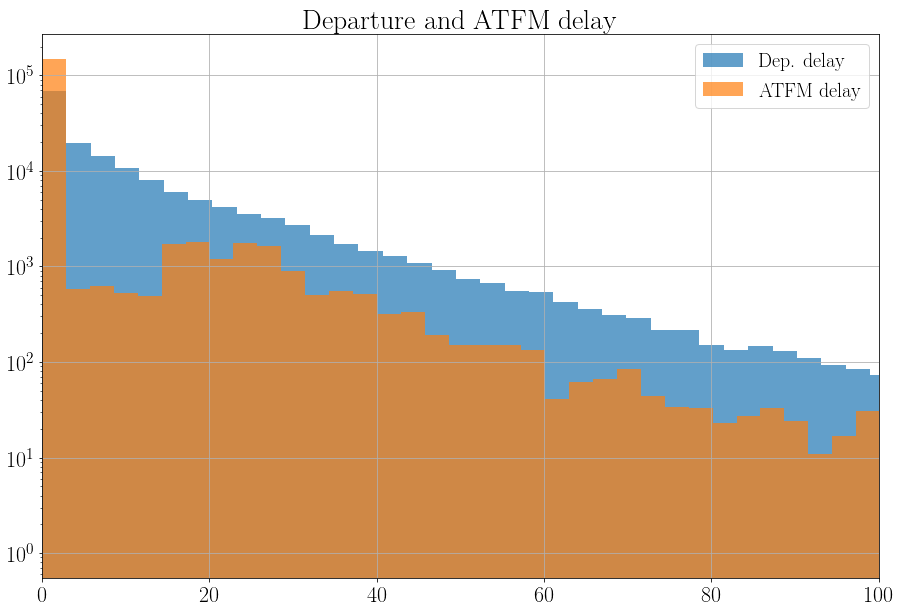

In [251]:
fig, ax = subplots(figsize=(15, 10))
df['departure_delay'].hist(bins=500, ax=ax, alpha=0.7, label='Dep. delay')
df['atfm_delay'].hist(bins=500, ax=ax, alpha=0.7, label='ATFM delay')
ax.legend()
ax.set_title('Departure and ATFM delay')
ax.set_xlim((0, 100))
ax.set_yscale('log')

(-20, 100)

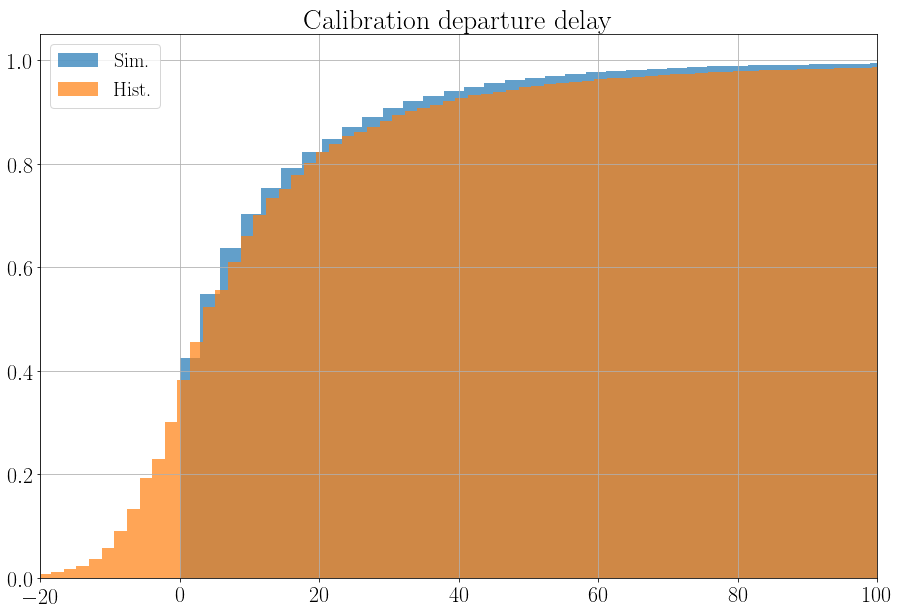

In [252]:
fig, ax = subplots(figsize=(15, 10))
df['departure_delay'].hist(bins=500, ax=ax, alpha=0.7, label='Sim.', cumulative=True, normed=True)
df_hist['departure_delay'].hist(bins=500, ax=ax, alpha=0.7, label='Hist.', cumulative=True, normed=True)
ax.legend()
ax.set_title('Calibration departure delay')
ax.set_xlim((-20, 100))
#ax.set_yscale('log')

(-20, 100)

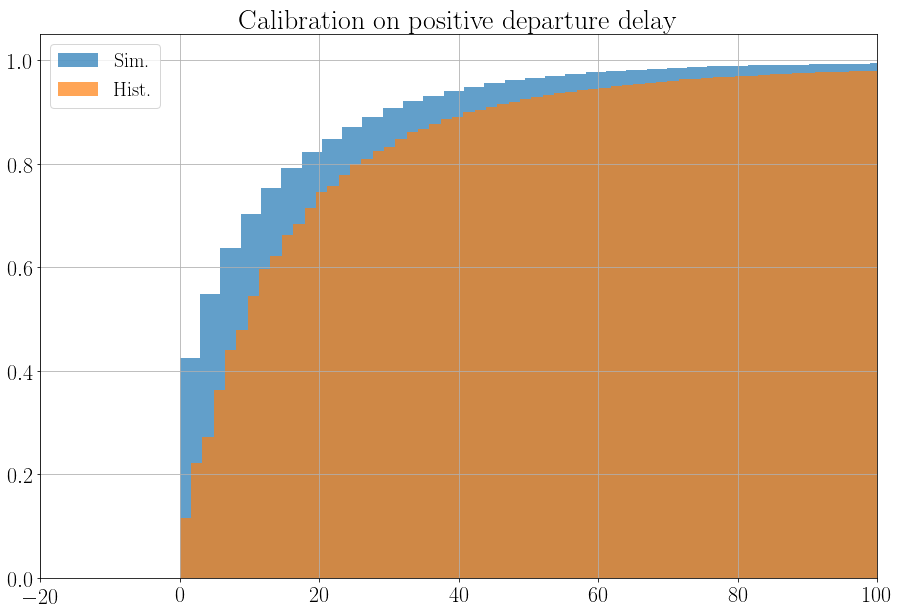

In [253]:
fig, ax = subplots(figsize=(15, 10))
df['departure_delay'].hist(bins=500, ax=ax, alpha=0.7, label='Sim.', cumulative=True, normed=True)
df_hist[df_hist['departure_delay']>=0.]['departure_delay'].hist(bins=500, ax=ax, alpha=0.7, label='Hist.', cumulative=True, normed=True)
ax.legend()
ax.set_title('Calibration on positive departure delay')
ax.set_xlim((-20, 100))
#ax.set_yscale('log')

In [254]:
# # departure delay per type of delay
# options = {'bins':100, 'cumulative':True, 'alpha':0.7, 'normed':True}
# fig, axes = subplots(3, 2, figsize=(15, 15))
# df[df['main_reason_delay']=='RD']['departure_delay'].hist(ax=axes[0][0], label='Sim.', **options)
# df[df['main_reason_delay']=='TA']['departure_delay'].hist(ax=axes[0][1], label='Sim.', **options)
# df[df['main_reason_delay']=='ER']['departure_delay'].hist(ax=axes[1][0], label='Sim.', **options)
# df[df['main_reason_delay']=='C']['departure_delay'].hist(ax=axes[1][1], label='Sim.', **options)
# df[df['main_reason_delay']=='W']['departure_delay'].hist(ax=axes[2][0], label='Sim.', **options)

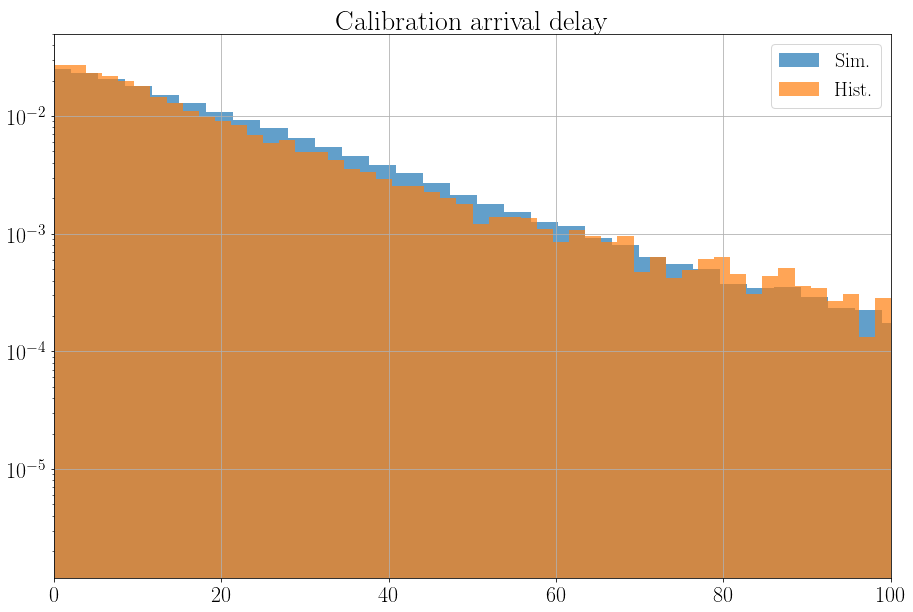

In [263]:
fig, ax = subplots(figsize=(15, 10))
df['arrival_delay'].hist(bins=500, ax=ax, alpha=0.7, label='Sim.', normed=True)
df_hist['arrival_delay'].hist(bins=500, ax=ax, alpha=0.7, label='Hist.', normed=True)
ax.legend()
ax.set_title('Calibration arrival delay')
ax.set_xlim((0, 100))
ax.set_yscale('log')

Text(0.5,1,'Calibration actual G2G time')

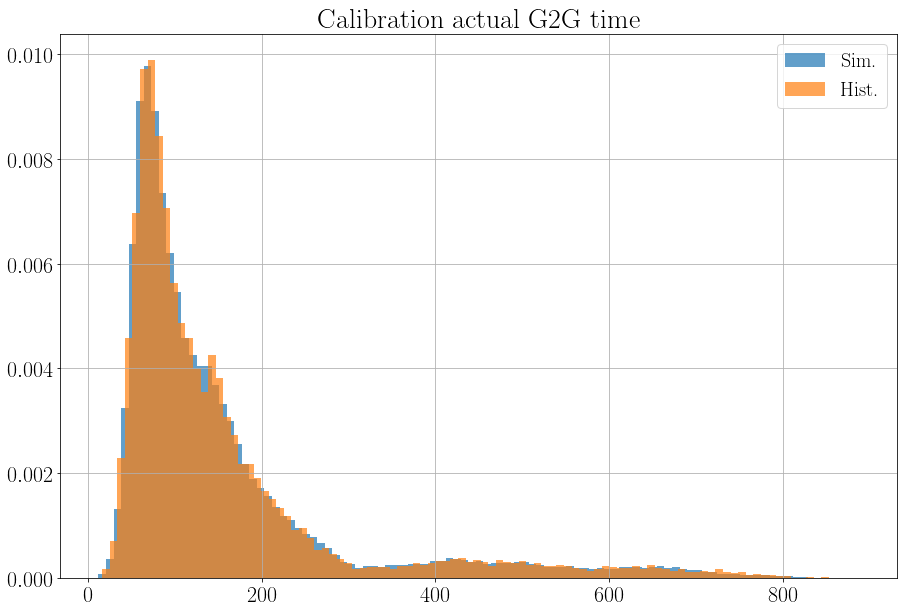

In [264]:
fig, ax = subplots(figsize=(15, 10))
df['actual_G2G_time'].hist(bins=100, ax=ax, alpha=0.7, label='Sim.', normed=True)
df_hist['actual_G2G_time'].hist(bins=100, ax=ax, alpha=0.7, label='Hist.', normed=True)
ax.legend()
ax.set_title('Calibration actual G2G time')
#ax.set_xlim((0, 100))
#ax.set_yscale('log')

Text(0.5,1,'Calibration actual flying time')

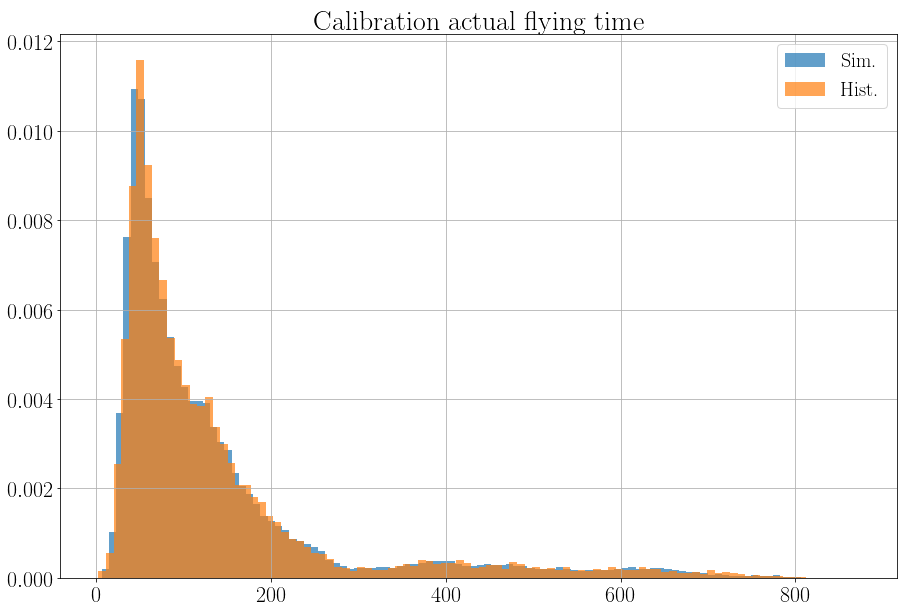

In [265]:
fig, ax = subplots(figsize=(15, 10))
df['actual_flying_time'].hist(bins=100, ax=ax, alpha=0.7, label='Sim.', normed=True)
df_hist['actual_flying_time'].hist(bins=100, ax=ax, alpha=0.7, label='Hist.', normed=True)
ax.legend()
ax.set_title('Calibration actual flying time')
#ax.set_xlim((0, 100))
#ax.set_yscale('log')

Text(0.5,1,'Calibration diff travelling time')

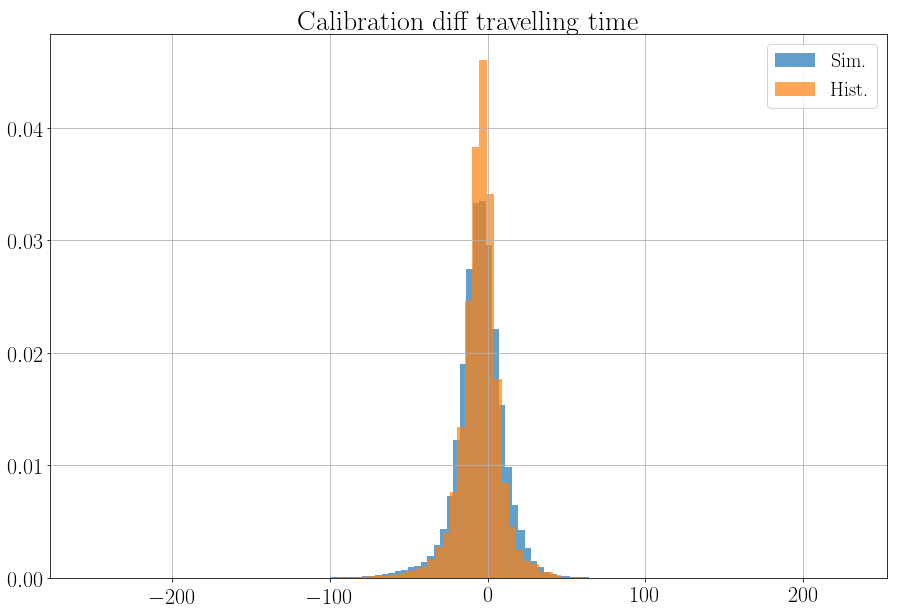

In [266]:
fig, ax = subplots(figsize=(15, 10))
df['travelling_time_diff'].hist(bins=100, ax=ax, alpha=0.7, label='Sim.', normed=True)
df_hist['travelling_time_diff'].hist(bins=100, ax=ax, alpha=0.7, label='Hist.', normed=True)
ax.legend()
ax.set_title('Calibration diff travelling time')
#ax.set_xlim((0, 100))
#ax.set_yscale('log')

Text(0.5,1,'Calibration flying distance')

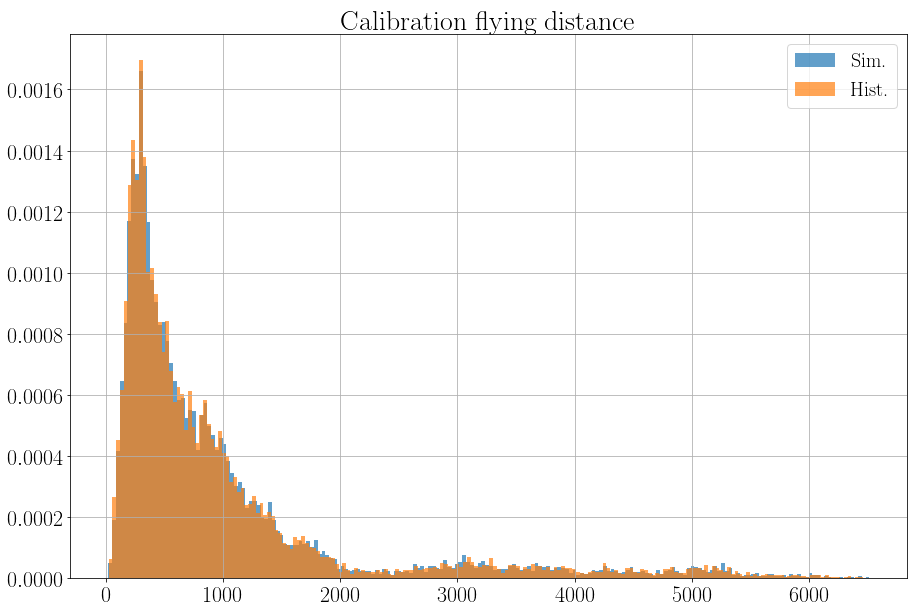

In [267]:
fig, ax = subplots(figsize=(15, 10))
df['scheduled_flying_distance'].hist(bins=200, ax=ax, alpha=0.7, label='Sim.', normed=True)
(df_hist['scheduled_flying_distance']).hist(bins=200, ax=ax, alpha=0.7, label='Hist.', normed=True)
ax.legend()
ax.set_title('Calibration flying distance')
#ax.set_xlim((0, 100))
#ax.set_yscale('log')

Text(0.5,1,'Types of ATFM reasons')

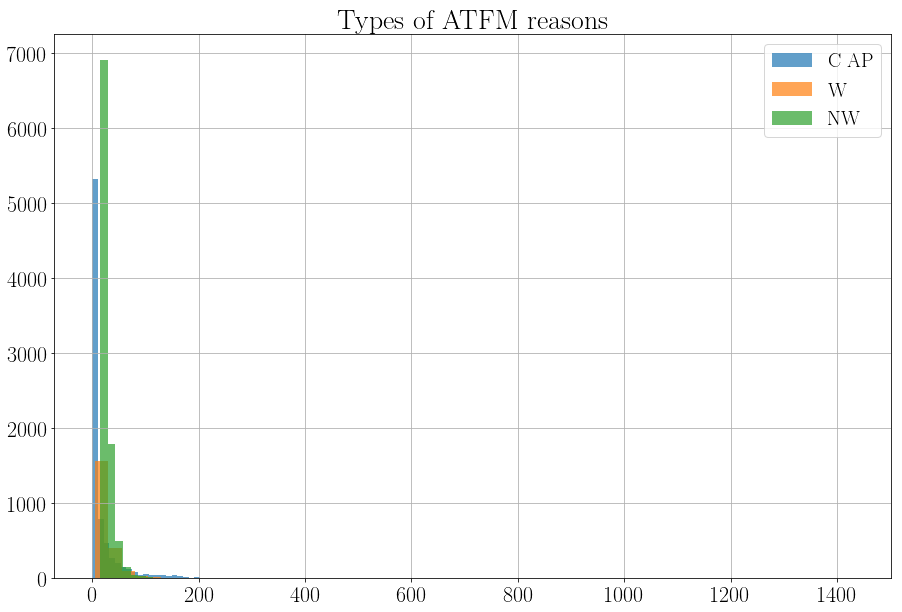

In [260]:
fig, ax = subplots(figsize=(15, 10))
mask = df['atfm_reason']=='C_AP'
df[mask]['atfm_delay'].hist(bins=20, ax=ax, alpha=0.7, label='C AP')
mask = df['atfm_reason']=='W'
df[mask]['atfm_delay'].hist(bins=20, ax=ax, alpha=0.7, label='W')
mask = df['atfm_reason']=='NW'
df[mask]['atfm_delay'].hist(bins=100, ax=ax, alpha=0.7, label='NW')
ax.legend()
ax.set_title('Types of ATFM reasons')
#ax = df['flight_time_diff'].hist(bins=500, figsize=(10, 7), label='Hist.')
#ax.set_xlim((0, 100))
#ax.set_yscale('log')

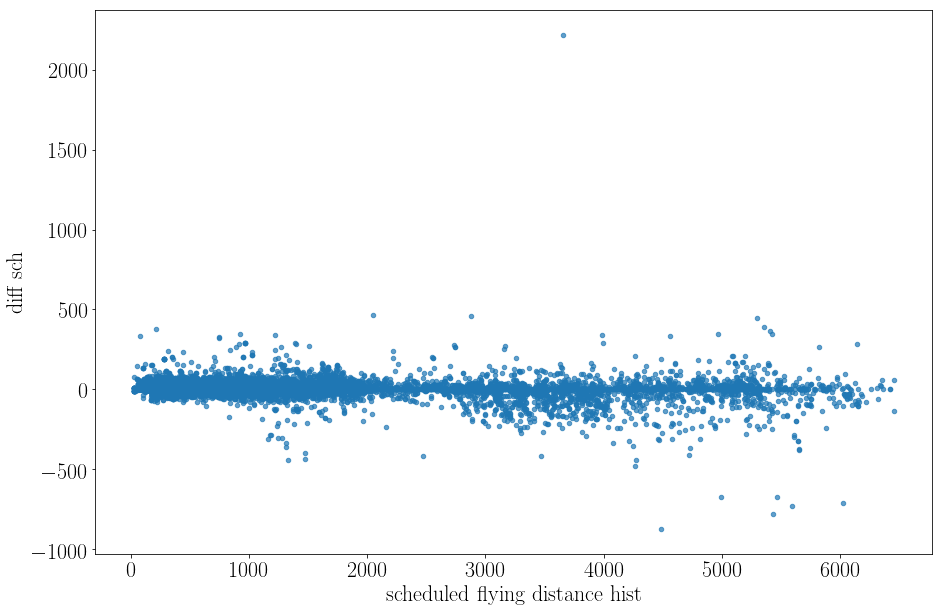

In [261]:
fig, ax = subplots(figsize=(15, 10))
go.rename(columns={col:col.replace('_', ' ') for col in go.columns}).plot(x='scheduled flying distance hist', y='diff sch', kind='scatter', ax=ax, alpha=0.7)#, label='Sim.')
# (df_hist['scheduled_flying_distance']).hist(bins=200, ax=ax, alpha=0.7, label='Hist.')
# ax.legend()
# ax.set_title('Calibration flying distance')

In [262]:
pouet = go[abs(go['diff_sch']/go['scheduled_flying_distance_hist'])>0.2]
pouet['ratio'] = pouet['diff_sch']/pouet['scheduled_flying_distance_hist']
pouet

,scheduled_flying_distance_hist,actual_flying_distance_hist,scheduled_flying_distance_sim,actual_flying_distance_sim,diff_sch,ratio
AA34820700,182.505400,182.505400,266.20,257.17,83.694600,0.458587
AA34910295,887.688985,906.587473,1151.73,1134.64,264.041015,0.297448
AA34911296,31.317495,31.317495,21.06,21.06,-10.257495,-0.327532
AA34911437,31.317495,31.317495,21.06,21.06,-10.257495,-0.327532
AA34911613,136.609071,135.529158,169.01,169.01,32.400929,0.237180
AA34911810,86.393089,93.952484,133.37,133.37,46.976911,0.543758
AA34911871,49.136069,62.634989,116.09,116.09,66.953931,1.362623
AA34911922,49.136069,49.136069,116.09,116.09,66.953931,1.362623
AA34911977,926.025918,926.025918,1269.44,NaN,343.414082,0.370847
AA34912002,49.136069,49.136069,116.09,116.09,66.953931,1.362623


In [192]:
pouet.to_csv('diff_distance.csv')